### 대회 개요

마스크를 착용하는 건 COIVD-19의 확산을 방지하는데 중요한 역할을 합니다. 제공되는 이 데이터셋은 사람이 마스크를 착용하였는지 판별하는 모델을 학습할 수 있게 해줍니다. 모든 데이터셋은 아시아인 남녀로 구성되어 있고 나이는 20대부터 70대까지 다양하게 분포하고 있습니다. 간략한 통계는 다음과 같습니다.

전체 사람 명 수 : 4,500   
한 사람당 사진의 개수: 7 [마스크 착용 5장, 이상하게 착용(코스크, 턱스크) 1장, 미착용 1장]   
이미지 크기: (384, 512)   

전체 데이터셋 중에서 60%는 학습 데이터셋으로 활용합니다.

입력값 : 마스크 착용 사진, 미착용 사진, 혹은 이상하게 착용한 사진(코스크, 턱스크)   
결과값 : 총 18개의 class를 예측해야합니다. 결과값으로 0~17에 해당되는 숫자가 각 이미지 당 하나씩 나와야합니다.



# EDA - Summary


#### **[문제]**
- Output : 18개의 Class로 분류  
    - 마스크를 썼는지? 쓰지 않았는지? 썼다면 알맞게 잘 썼는지?
    - 여자인지? 남자인지?
    - 연령은 어떻게 되는지?   
    => 3가지 문제를 종합한 18개의 Class


#### **[EDA - train]**
- 변수 구성 파악
    - `gender`(범주형) : 남(1042), 여(1658)로 구성되며 클래스 불균형 있음
    - `race`(범주형) : 'Asian'으로만 구성
    - `path`(범주형) : 파일 경로
    - `age` (수치형) : 나이 구성
        -> 목적 클래스에 맞게 `age1`(30세 미만), `age2`(30세 이상 60세 미만), `age3`(60세 이상)으로 카테고리화
        -> 최고값은 60세 즉, 60세 이상의 구성은 60세가 전부
        -> 20세 구간에 데이터가 가장 많이 분포하며, 60세와 가까운 50대 후반 또한 데이터가 많이 분포함 -> 60세와 어떻게 구분할지 고민
- 그룹핑
    - `gender`와 `age`그룹으로 비교해본 결과 특히 `age2`(30세 이상 60세 미만)그룹에서 여자인 데이터가 많은 것으로 나타났다. (육안으로 거의 2배)


#### **[EDA - Image]**
- image size : (384, 512)
- 한 사람당 사진의 개수는 모두 7장임을 확인
- `30세 이상 60세 미만` 그룹과 `60세 이상` 그룹을 육안으로도 구분하기 쉽지 않음
- 마스크를 쓴 경우 남여 구분이 어려움 -> 얼굴이 가려진 경우 헤어스타일이나 눈, 눈썹 등으로 볼 수 있는데 여성분들도 짧은 머리가 많음

#### **[주요하게 고민해볼 점]**
1. 마스크를 썼는지? 쓰지 않았는지?
    - 마스크를 쓴 사진 중 알맞게 착용했는지 여부를 파악하는 것이 핵심일 듯
    - 턱 라인, 코 라인이 있는 경우를 잘못 쓴것으로 인식하도록 할 수 있을지?
2. 여자인지? 남자인지?
3. 연령은 어떻게 되는지?   
    - 50대와 60대를 구분하는게 핵심일 것
    - 60대는 60세 밖에 존재하지 않으며, age2(30세 이상 60세 미만)와 age3(60세 이상)는 육안으로 쉽게 구분되지 않는다.

[문제]
- Output : 18개의 Class로 분류  
    - 마스크를 썼는지? 쓰지 않았는지? 썼다면 알맞게 잘 썼는지?
    - 여자인지? 남자인지?
    - 연령은 어떻게 되는지?   
    => 3가지 문제를 종합한 18개의 Class

In [1]:
from PIL import Image
from itertools import chain

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, random

# EDA1. train.csv 데이터

In [7]:
train = pd.read_csv('/opt/ml/input/data/train/train.csv')
train.head()

id  gender   race  age                    path
0  000001  female  Asian   45  000001_female_Asian_45
1  000002  female  Asian   52  000002_female_Asian_52
2  000004    male  Asian   54    000004_male_Asian_54
3  000005  female  Asian   58  000005_female_Asian_58
4  000006  female  Asian   59  000006_female_Asian_59

In [8]:
train.describe()

age
count  2700.000000
mean     37.708148
std      16.985904
min      18.000000
25%      20.000000
50%      36.000000
75%      55.000000
max      60.000000

In [9]:
train['race'].value_counts()

Asian    2700
Name: race, dtype: int64

female    1658
male      1042
Name: gender, dtype: int64

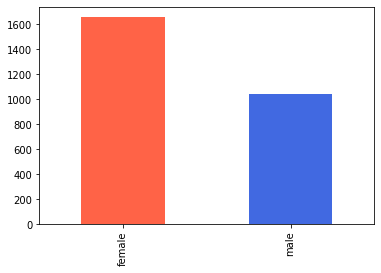

In [11]:
train['gender'].value_counts().plot(kind='bar', color=['tomato', 'royalblue'])
train['gender'].value_counts()

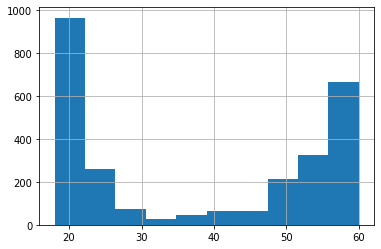

In [12]:
train['age'].hist()

In [18]:
def age_to_category(age):
    if age < 30:
        age = "age1" # 30세 미만
    elif 30 <= age and age < 60:
        age = "age2" # 30세 이상 60세 미만
    elif age >= 60:
        age = "age3" # 60세 이상
    return age

train['age_group'] = train['age'].apply(age_to_category)
train.head()

id  gender   race  age                    path age_group
0  000001  female  Asian   45  000001_female_Asian_45      age2
1  000002  female  Asian   52  000002_female_Asian_52      age2
2  000004    male  Asian   54    000004_male_Asian_54      age2
3  000005  female  Asian   58  000005_female_Asian_58      age2
4  000006  female  Asian   59  000006_female_Asian_59      age2

In [19]:
train['age_group'].value_counts().sort_index()

age1    1281
age2    1227
age3     192
Name: age_group, dtype: int64

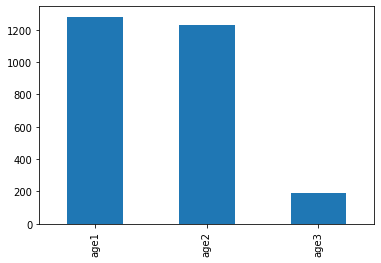

In [20]:
train['age_group'].value_counts().sort_index().plot(kind='bar')

In [21]:
group = train.groupby('gender')['age_group'].value_counts().sort_index()
group

gender  age_group
female  age1         732
        age2         817
        age3         109
male    age1         549
        age2         410
        age3          83
Name: age_group, dtype: int64

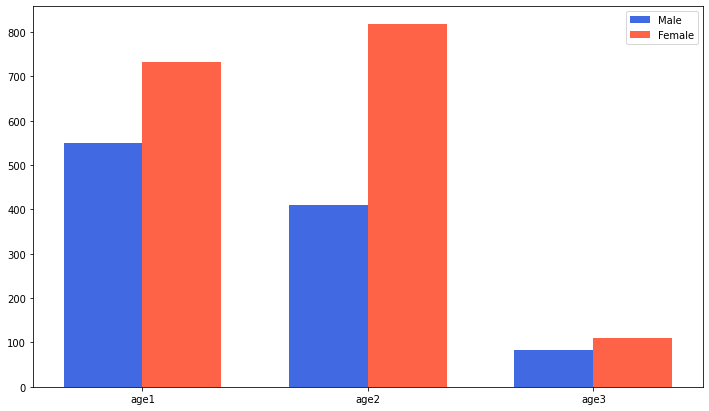

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

idx = np.arange(len(group['male'].index))
width=0.35

ax.bar(idx-width/2, group['male'], 
       color='royalblue',
       width=width,
       label='Male')

ax.bar(idx+width/2, group['female'], 
       color='tomato',
       width=width,
       label='Female')

ax.set_xticks(idx)
ax.set_xticklabels(group['male'].index)
ax.legend()



plt.show()

# EDA2. Image data

### raw_data 폴더에서 이미지 구성 확인

In [39]:
raw_folder_dir = '/opt/ml/input/data/train/images/'

folder_name = os.listdir(raw_folder_dir)
folder_name = list(set([x.replace('._','') for x in folder_name]))
file_list = [[folder_name[i]+"/"+file for file in os.listdir(os.path.join(raw_folder_dir,folder_name[i])) if '._' not in file and 'ipynb' not in file] for i in range(len(folder_name))]

all_file_list = list(chain(*file_list)) # 전체 파일명
jpg_file_list = [file for file in all_file_list if file[-4:] == '.jpg']  # jpg 확장자가 아닌 파일명
not_jpg_file_list = [file for file in all_file_list if file[-4:] != '.jpg']  # jpg 확장자가 아닌 파일명
check_extension = [file[-4:] for file in all_file_list if file[-4:] != '.jpg'] # jpg 외의 확장자만 따로 구분 (카운트용)

print("전체 파일 개수: ",len(all_file_list))
print("폴더별 이미지 개수: ", set([len(file) for file in file_list]))
print("jpg 확장자인 파일 개수: ",len(jpg_file_list))
print("jpg 확장자가 아닌 파일 개수: ",len(not_jpg_file_list))
print("png 확장자인 파일 개수: ", check_extension.count('.png'))
print("jpeg 확장자인 파일 개수: ", check_extension.count('jpeg'))

전체 파일 개수:  18900
폴더별 이미지 개수:  {7}
jpg 확장자인 파일 개수:  18035
jpg 확장자가 아닌 파일 개수:  865
png 확장자인 파일 개수:  511
jpeg 확장자인 파일 개수:  354


In [40]:
folder_dir = '/opt/ml/input/data_re/train/re_images/dir_test'
folder_name = os.listdir(folder_dir)

file_list = [[folder_name[i]+"/"+file for file in os.listdir(os.path.join(folder_dir,folder_name[i])) if '._' not in file and 'ipynb' not in file] for i in range(len(folder_name))]

# 모든 이미지명 리스트
all_file_list = list(chain(*file_list))

# class별 이미지명 리스트
incorrect_img = file_list[0]
normal_img = file_list[1]
mask_img = file_list[2]

print('모든 이미지 수: ', len(all_file_list))
print('{} class 이미지 수:'.format(folder_name[0]), len(incorrect_img))
print('{} class 이미지 수:'.format(folder_name[1]), len(normal_img))
print('{} class 이미지 수:'.format(folder_name[2]), len(mask_img))

모든 이미지 수:  18900
incorrect class 이미지 수: 2700
normal class 이미지 수: 2700
mask class 이미지 수: 13500


알맞게 착용하지 않은 마스크 이미지는 어떤 방식으로 착용한 것인지 보고, 연령대 별 사진을 찾아보기

In [41]:
incorrect_female_age1_img = sorted([img for img in incorrect_img if 'female' and 'age1' in img], key=lambda x: x.split('_')[3])
incorrect_female_age2_img = sorted([img for img in incorrect_img if 'female' and 'age2' in img], key=lambda x: x.split('_')[3])
incorrect_female_age3_img = sorted([img for img in incorrect_img if 'female' and 'age3' in img], key=lambda x: x.split('_')[3])
incorrect_male_age1_img = sorted([img for img in incorrect_img if 'female' not in img and 'age1' in img], key=lambda x: x.split('_')[3])
incorrect_male_age2_img = sorted([img for img in incorrect_img if 'female' not in img and 'age2' in img], key=lambda x: x.split('_')[3])
incorrect_male_age3_img = sorted([img for img in incorrect_img if 'female' not in img and 'age3' in img], key=lambda x: x.split('_')[3])

In [42]:
choice_1 = random.choices(incorrect_female_age1_img, k=8)
choice_2 = random.choices(incorrect_female_age2_img, k=8)
choice_3 = random.choices(incorrect_female_age3_img, k=8)

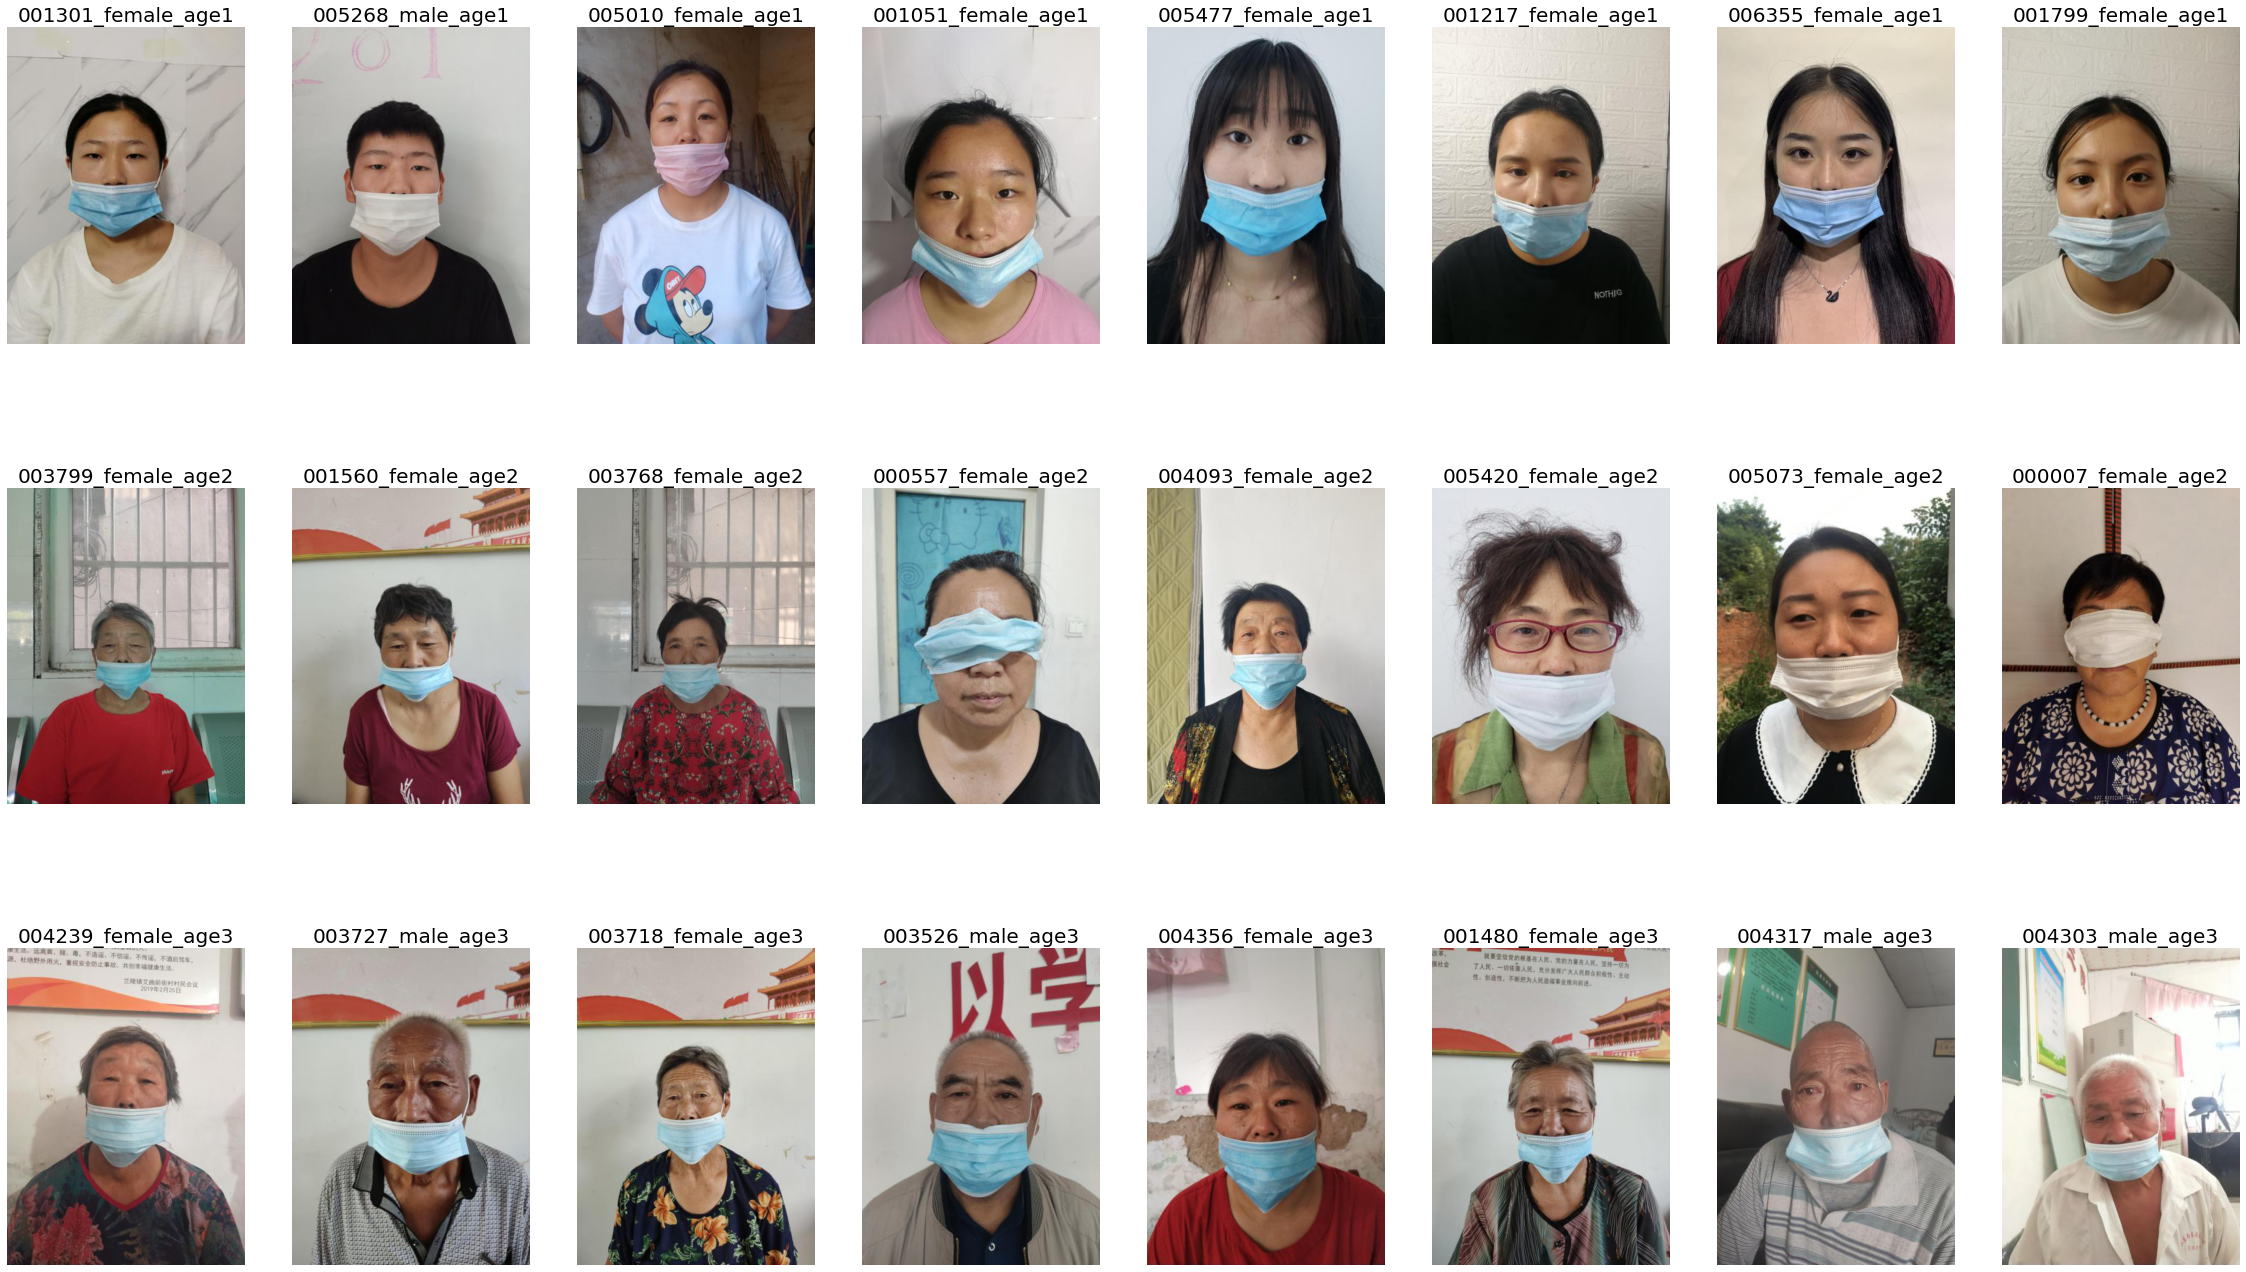

In [44]:
# 턱스크&마스크 사진 중 나이별 여자 8명씩
fig, axes = plt.subplots(3, 8, figsize=(40, 24))
plt.rc('axes', titlesize=20)

choice = random.choices(incorrect_female_age3_img, k=8)

test_img = choice_1 + choice_2 + choice_3

for idx, image in enumerate(test_img):
    name_split = image.split('/')[1].split('_')
    name = '_'.join(name_split[:2])+'_'+name_split[3]
    
    axes[idx//8][idx%8].imshow(Image.open(os.path.join(folder_dir, image)))
    axes[idx//8][idx%8].set_title(name)
    axes[idx//8][idx%8].axis('off')        

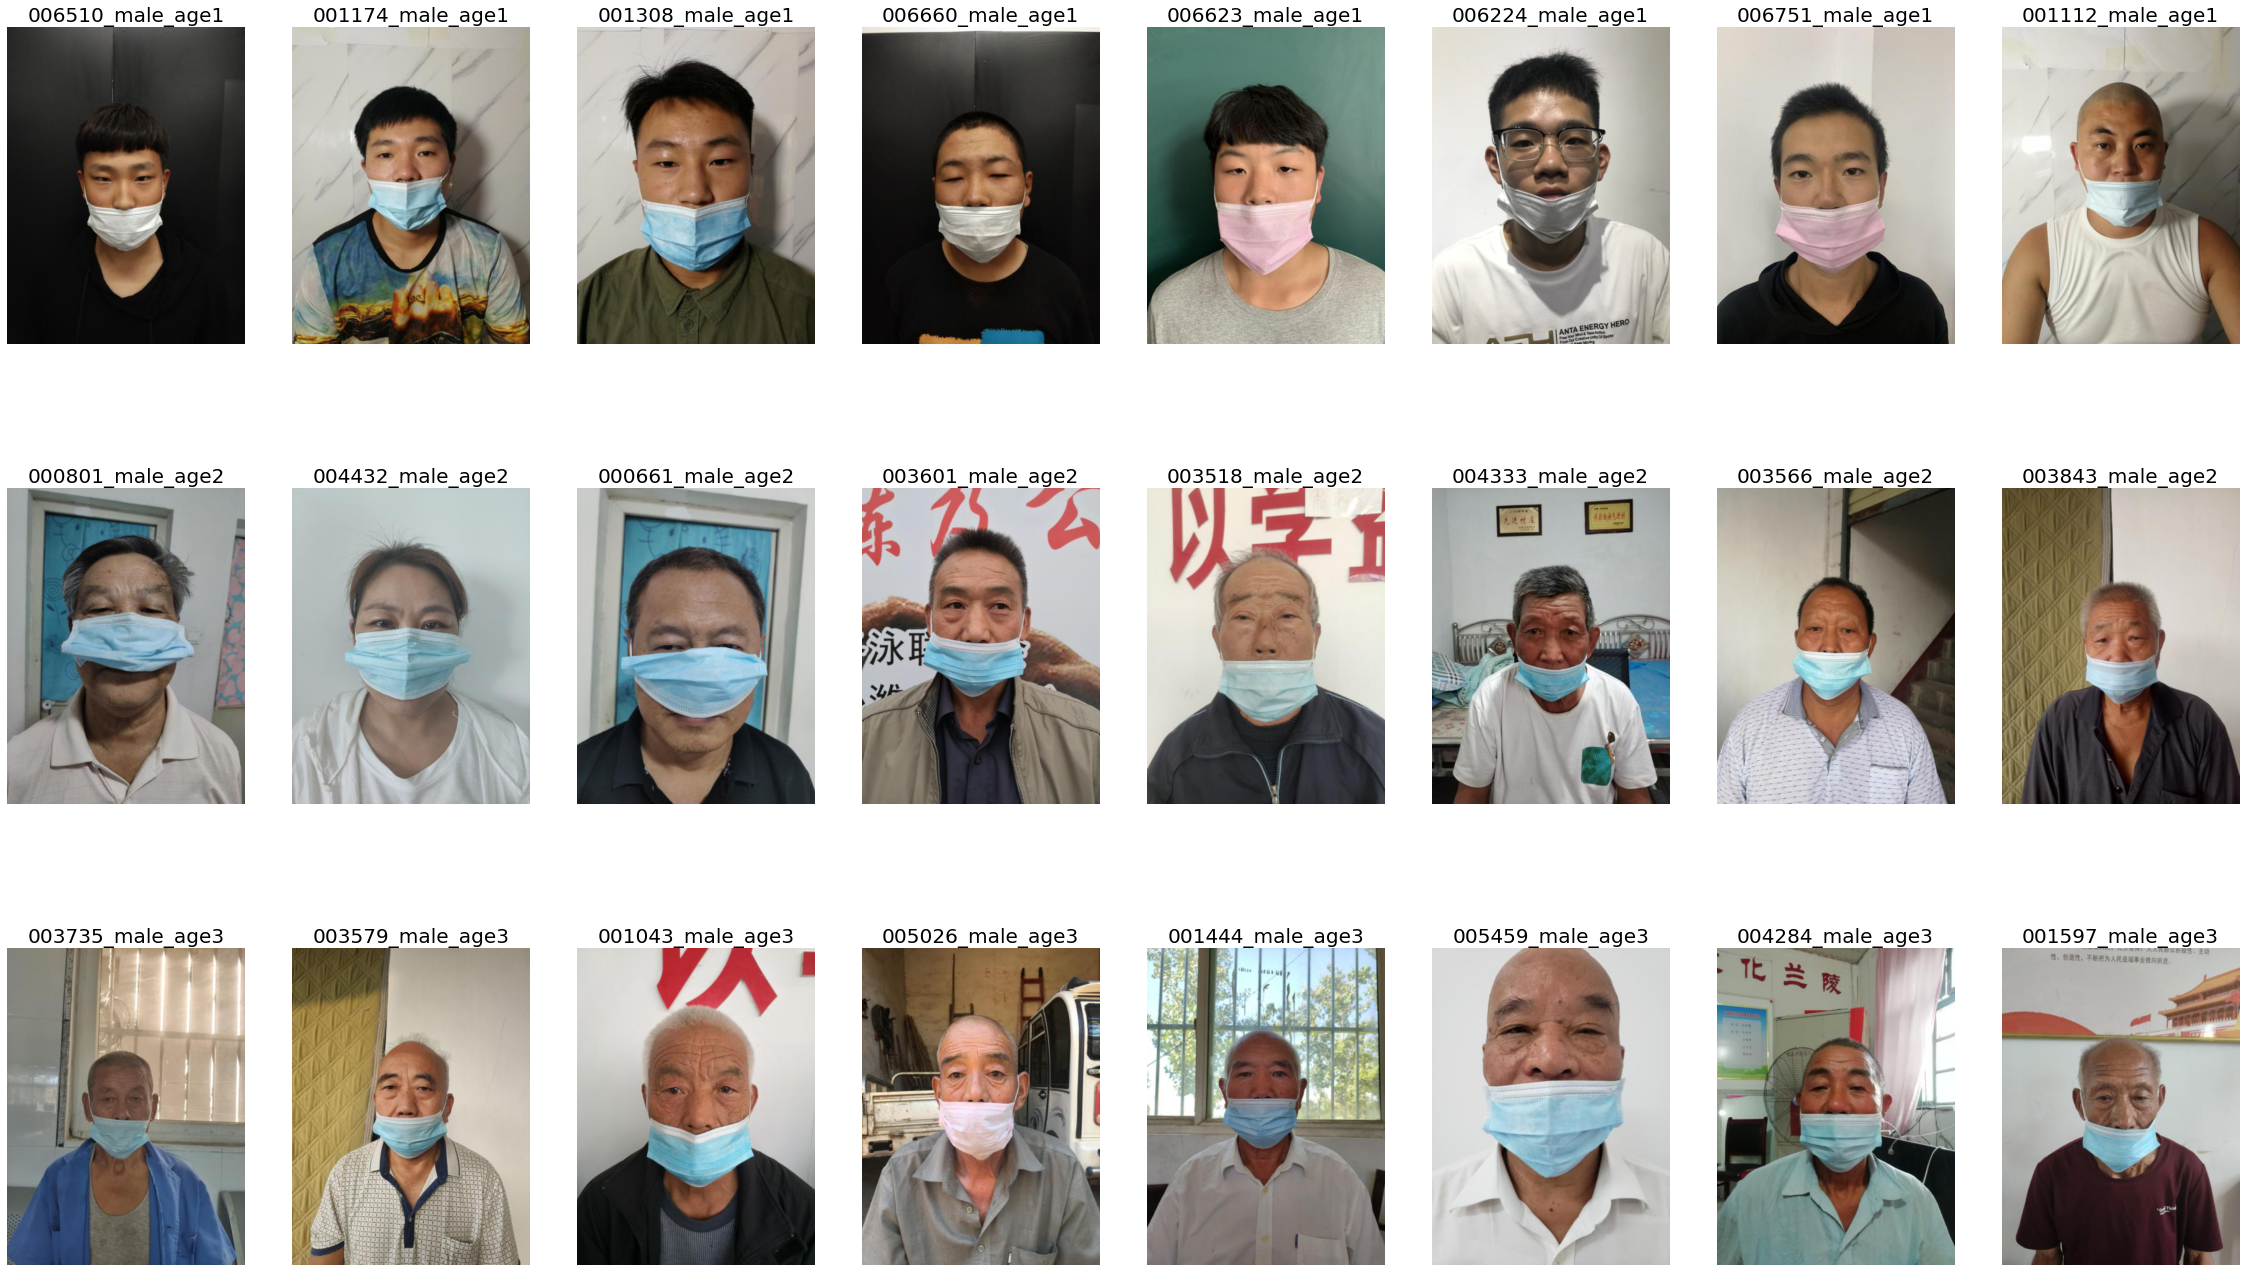

In [ ]:
# 턱스크&마스크 사진 중 나이별 남자 8명씩
fig, axes = plt.subplots(3, 8, figsize=(40, 24))
plt.rc('axes', titlesize=20)

test_img = incorrect_male_img[:8] + incorrect_male_img[800:808] + incorrect_male_img[-8:]

for idx, image in enumerate(test_img):
    name_split = image.split('/')[1].split('_')
    name = '_'.join(name_split[:2])+'_'+name_split[3]
    
    axes[idx//8][idx%8].imshow(Image.open(image))
    axes[idx//8][idx%8].set_title(name)
    axes[idx//8][idx%8].axis('off')        